In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), device

(1, device(type='cuda', index=0))

In [2]:
!nvidia-smi

Sat Sep 21 03:01:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:C1:00.0 Off |                  N/A |
| 30%   28C    P8              21W / 350W |      6MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
import sys
IS_GCOLAB = 'google.colab' in sys.modules

In [4]:
from pathlib import Path

_base_libpath = Path(
    f"{os.environ['HOME']}/_self_research/24.08.sea_vl/sea-vl-experiments/WIT"
)
assert _base_libpath.exists()

os.chdir(_base_libpath)

In [ ]:
!pwd

$$$/sea-vl-experiments/WIT


---

In [ ]:
import datasets
from datasets import load_dataset
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer

import os
import requests
import pickle
from PIL import Image
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd

import time
from tqdm import tqdm

$$$/miniconda3/envs/uwow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
_datasets_ = {
    "test":   f"out/wit_sea_test_all_idx_0_to_7320.csv",
    "valid":  f"out/wit_sea_validation_all_idx_0_to_8393.csv",
    "train0": f"out/wit_sea_train_idx_0_to_10000.csv",
    **{
        f"train{_}": f"out/wit_sea_train_idx_{_}0000_to_{_+1}0000.csv"
        for _ in range(1,8)
    },
}

In [7]:
dataframes = {k: pd.read_csv(v, index_col=0) for k, v in _datasets_.items()}
image_urls = {
    k: list(v.image_url.to_dict().values())
    for k, v in dataframes.items()
}

In [ ]:
for k, v in image_urls.items():
    a, b = len(v), len(set(v))
    print(f"{k:>8}", a, b, f"{b / a:6.1%}", sep=", ")

    test, 306, 214,  69.9%
   valid, 307, 251,  81.8%
  train0, 371, 367,  98.9%
  train1, 382, 381,  99.7%
  train2, 397, 395,  99.5%
  train3, 372, 371,  99.7%
  train4, 373, 373, 100.0%
  train5, 371, 369,  99.5%
  train6, 391, 389,  99.5%
  train7, 361, 361, 100.0%


In [ ]:
#%%
wew = [__ for _ in range(8) for __ in image_urls[f"train{_}"]]

#%%
if True:
    k = "train(0-7)"
    a, b = len(wew), len(set(wew))
    print(f"{k:>8}", a, b, f"{b / a:6.1%}", sep=", ")

train(0-7), 3018, 2946,  97.6%


In [ ]:
#%%
uniqs = {k: set(v) for k, v in image_urls.items()}
for _ in range(8):
    assert len(uniqs["test"] & uniqs[f"train{_}"]) == len(uniqs["valid"] & uniqs[f"train{_}"]) == 0

In [ ]:
dataframes["valid"].groupby("image_url").filter(lambda df: len(df)>1).sort_values("image_url")

,language,page_url,image_url,page_title,section_title,hierarchical_section_title,caption_reference_description,caption_attribution_description,caption_alt_text_description,mime_type,original_height,original_width,is_main_image,attribution_passes_lang_id,page_changed_recently,context_page_description
305,id,https://id.wikipedia.org/wiki/Kunak,http://upload.wikimedia.org/wikipedia/commons/...,Kunak,NaN,Kunak,NaN,English: Sabah: Location map of District and T...,Lokasi Kunak,image/png,1652,2000,True,True,True,Kunak adalah sebuah kota kecil yang terletak d...
33,vi,https://vi.wikipedia.org/wiki/Kunak,http://upload.wikimedia.org/wikipedia/commons/...,Kunak,NaN,Kunak,NaN,English: Sabah: Location map of District and T...,Vị trí của Huyện Kunak,image/png,1652,2000,True,True,True,Huyện Kunak là một huyện thuộc bang Sabah của ...
182,war,https://war.wikipedia.org/wiki/Hadji_Panglima_...,http://upload.wikimedia.org/wikipedia/commons/...,Hadji Panglima Tahil,NaN,Hadji Panglima Tahil,NaN,English: Map of the Sulu showing the location ...,Mapa han Sulu nga nagpapakita kon hain nahamut...,image/png,250,300,True,True,True,An Hadji Panglima Tahil usa nga ika-unom nga k...
132,ceb,https://ceb.wikipedia.org/wiki/Hadji_Panglima_...,http://upload.wikimedia.org/wikipedia/commons/...,"Hadji Panglima Tahil, Sulu",NaN,"Hadji Panglima Tahil, Sulu",NaN,English: Map of the Sulu showing the location ...,Mapa sa Sulu nga nagpakita sa nahimutangan sa ...,image/png,250,300,True,True,True,Ang Hadji Panglima Tahil ikaunom nga klaseng m...
142,fil,https://tl.wikipedia.org/wiki/Hadji_Panglima_T...,http://upload.wikimedia.org/wikipedia/commons/...,Hadji Panglima Tahil,NaN,Hadji Panglima Tahil,Mapa ng Sulu na nagpapakita sa lokasyon ng Had...,English: Map of the Sulu showing the location ...,Mapa ng Sulu na nagpapakita sa lokasyon ng Had...,image/png,250,300,True,True,True,Ang Bayan ng Hadji Panglima Tahil ay isang ika...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,ceb,https://ceb.wikipedia.org/wiki/Buceros,https://upload.wikimedia.org/wikipedia/commons...,Buceros,NaN,Buceros,NaN,Rhinoceros hornbill at the National Aviary in ...,NaN,image/jpeg,1792,2148,True,True,True,Henero sa mga langgam ang Buceros. Ang Buceros...
49,id,https://id.wikipedia.org/wiki/Toko_Kompak,https://upload.wikimedia.org/wikipedia/commons...,Toko Kompak,NaN,Toko Kompak,"Toko Kompak, Pasar Baru",Toko Kompak Pasar Baru.JPG English: Toko Kompa...,NaN,image/jpeg,1944,2592,True,True,True,Toko Kompak adalah sebuah markah tanah sejarah...
65,id,https://id.wikipedia.org/wiki/Tio_Tek_Ho,https://upload.wikimedia.org/wikipedia/commons...,Tio Tek Ho,NaN,Tio Tek Ho,"Toko Kompak, kediaman keluarga Kapitan Tio Tek...",Toko Kompak Pasar Baru.JPG English: Toko Kompa...,NaN,image/jpeg,1944,2592,True,True,True,Majoor Tio Tek Ho adalah seorang birokrat Cina...
210,vi,https://vi.wikipedia.org/wiki/An_Giang,https://upload.wikimedia.org/wikipedia/vi/b/b4...,An Giang,Tỉnh Long Xuyên và tỉnh Châu Đốc thời Pháp thuộc,An Giang / Lịch sử / Tỉnh Long Xuyên và tỉnh C...,An Giang thời Pháp thuộc bị chia nhỏ (1878) và...,Bản đồ hành chính Nam Kỳ thuộc Pháp (Cochinchi...,NaN,image/jpeg,5323,7000,True,True,True,An Giang là một tỉnh thuộc vùng đồng bằng sông...


Dataset Check

In [8]:
Image.MAX_IMAGE_PIXELS = None

In [9]:
#%%
def invalid_images_as_none(batch):
    images = []
    # headers = {'User-Agent': f'SEACrowd/Cultural-Images (https://github.com/SEACrowd; nusacrowd@gmail.com; {os.environ["EMAIL"]})'}
    headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
    for image_url in batch["image_url"]:
        try:
            req = requests.get(image_url, headers=headers, stream=True, timeout=8)
            req.raise_for_status()
            image = Image.open(req.raw).convert('RGB')
        except (Exception, Warning) as e:
            # if isinstance(e, Exception):
            #     print(f"Failed to download {img_url}: {e}")
            # elif isinstance(e, Warning):
            #     print(f"Warning: {w}")
            image = None
            # print(req, e, image_url, sep='\n', end='\n\n')
            # raise e
        images.append(image)
    batch["image"] = images
    # print(len(list(filter(None, images))))
    return batch

Sequential

In [ ]:
for img_url in dataframes["test"].image_url.drop_duplicates().values:
    batch = {"image_url": [img_url]}
    invalid_images_as_none(batch)
    break

In [ ]:
headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
for img_url in dataframes["test"].image_url.drop_duplicates().values:
    try:
        response = requests.get(img_url, stream=True, timeout=8, headers=headers)
        response.raise_for_status()
        image = Image.open(response.raw).convert('RGB')
    # except:
    #     pass
    except Exception as e:
        print(f"Failed to download {img_url}: {e}")

In [ ]:
# #%%
# %%time
# seq_times = []
# nd = len(dset)

# non_none_count = 0
# start_time = time.time()
# for i, batch in enumerate(dset):
#     end_time = time.time()
#     seq_times.append(end_time - start_time)
#     non_none_count += 1 if batch["image"] is not None else 0
#     if i >= nd:
#         break
#     start_time = time.time()
# print("non-None Images Count:", non_none_count)

Parallel

In [10]:
#%%
def get_dset(subset):
    dset = datasets.Dataset.from_pandas(dataframes[subset])
    dset = dset.with_transform(invalid_images_as_none)
    dset_uniqimg = datasets.Dataset.from_pandas(dataframes[subset].drop_duplicates("image_url"))
    dset_uniqimg = dset_uniqimg.with_transform(invalid_images_as_none)
    return dset, dset_uniqimg

In [11]:
#%%
def get_loader(ds, bs=8):
    return DataLoader(
        ds, batch_size=bs, num_workers=bs,
        collate_fn=lambda x: {k: [row[k] for row in x] for k in x[0]}
    )

In [20]:
#%%
def iterating(ds, bs=8):
    nd = len(ds)
    loader = get_loader(ds, bs)

    bs_times = []
    item_count = 0
    non_none_count = 0

    start_time = time.time()
    for batch in loader:
        item_count += len(batch['page_title'])
        end_time = time.time()
        bs_times.append(end_time - start_time)
        non_none_count += sum(map(lambda i: i is not None, batch["image"]))
        if item_count >= nd:
            break
        start_time = time.time()

    return bs_times, item_count, non_none_count

Do Timing

In [12]:
dset, dset_uniqimg = get_dset("test")

In [ ]:
#%%
%%time
bs8_times, item_count, non_none_count = iterating(dset, bs=8)

In [ ]:
#%%
%%time
bs16_times, item_count, non_none_count = iterating(dset, bs=16)

CPU times: user 27.1 ms, sys: 240 ms, total: 267 ms
Wall time: 10.4 s


In [ ]:
Image.MAX_IMAGE_PIXELS = None
BS = 32
for subset in dataframes.keys():
    print(f" [{subset}]")
    dset, dset_uniqimg = get_dset(subset)

    time_st = time.time()
    _, item_cnt, non_none_cnt = iterating(dset, bs=BS)
    print(f"  {round((time.time()-time_st),2)}s")
    assert item_cnt == len(dset)

    time_st = time.time()
    _, item_cnt_uniq, non_none_cnt_uniq = iterating(dset_uniqimg, bs=BS)
    print(f"  {round((time.time()-time_st),2)}s")
    assert item_cnt_uniq == len(dset_uniqimg)

    print("Dataset Count: ", item_cnt)
    print("Unique Images: ", item_cnt_uniq, f" ({item_cnt_uniq / item_cnt :5.1%})")
    print("non-None Imgs: ", f"{non_none_cnt:3}", f" ({non_none_cnt / item_cnt :5.1%})")
    print("non-None Uniqs: ", non_none_cnt_uniq, f" ({non_none_cnt_uniq / item_cnt :5.1%})")

    print()

 [test]
  28.41s
  29.74s
Dataset Count:  306
Unique Images:  214  (69.9%)
non-None Imgs:  294  (96.1%)
non-None Uniqs:  206  (67.3%)

 [valid]
  45.52s
  45.66s
Dataset Count:  307
Unique Images:  251  (81.8%)
non-None Imgs:  261  (85.0%)
non-None Uniqs:  207  (67.4%)

 [train0]


$$$/miniconda3/envs/uwow/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  33.28s


$$$/miniconda3/envs/uwow/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  33.15s
Dataset Count:  371
Unique Images:  367  (98.9%)
non-None Imgs:  356  (96.0%)
non-None Uniqs:  352  (94.9%)

 [train1]
  33.2s
  32.48s
Dataset Count:  382
Unique Images:  381  (99.7%)
non-None Imgs:  364  (95.3%)
non-None Uniqs:  363  (95.0%)

 [train2]
  30.15s
  30.48s
Dataset Count:  397
Unique Images:  395  (99.5%)
non-None Imgs:  382  (96.2%)
non-None Uniqs:  380  (95.7%)

 [train3]
  33.16s
  32.77s
Dataset Count:  372
Unique Images:  371  (99.7%)
non-None Imgs:  362  (97.3%)
non-None Uniqs:  361  (97.0%)

 [train4]
  32.21s
  32.5s
Dataset Count:  373
Unique Images:  373  (100.0%)
non-None Imgs:  349  (93.6%)
non-None Uniqs:  349  (93.6%)

 [train5]
  38.5s
  38.16s
Dataset Count:  371
Unique Images:  369  (99.5%)
non-None Imgs:  352  (94.9%)
non-None Uniqs:  350  (94.3%)

 [train6]
  32.09s
  32.66s
Dataset Count:  391
Unique Images:  389  (99.5%)
non-None Imgs:  373  (95.4%)
non-None Uniqs:  371  (94.9%)

 [train7]
  37.0s
  36.54s
Dataset Count:  361
Unique Images: 

In [ ]:
# request without header

 [test]
  13.67s
  9.68s
Dataset Count:  306
Unique Images:  214  (69.9%)
non-None Imgs:   43  (14.1%)
non-None Uniqs:  25  ( 8.2%)

 [valid]
  14.35s
  11.42s
Dataset Count:  307
Unique Images:  251  (81.8%)
non-None Imgs:   53  (17.3%)
non-None Uniqs:  34  (11.1%)

 [train0]
  16.6s
  15.61s
Dataset Count:  371
Unique Images:  367  (98.9%)
non-None Imgs:   54  (14.6%)
non-None Uniqs:  52  (14.0%)

 [train1]
  16.42s
  15.59s
Dataset Count:  382
Unique Images:  381  (99.7%)
non-None Imgs:   46  (12.0%)
non-None Uniqs:  46  (12.0%)

 [train2]
  17.02s
  18.41s
Dataset Count:  397
Unique Images:  395  (99.5%)
non-None Imgs:   77  (19.4%)
non-None Uniqs:  76  (19.1%)

 [train3]
  17.47s
  16.39s
Dataset Count:  372
Unique Images:  371  (99.7%)
non-None Imgs:   71  (19.1%)
non-None Uniqs:  70  (18.8%)

 [train4]
  16.21s
  16.45s
Dataset Count:  373
Unique Images:  373  (100.0%)
non-None Imgs:   49  (13.1%)
non-None Uniqs:  49  (13.1%)

 [train5]
  15.66s
  16.72s
Dataset Count:  371
Uniq

---
### Vectorization

In [14]:
model = SentenceTransformer("sentence-transformers/clip-ViT-B-32").to('cuda')

/home/is/frederikus-h/miniconda3/envs/uwow/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
def wit_img2embed(subset, bs=8):
    dset, _ = get_dset(subset)
    loader = get_loader(dset, bs=bs)

    _images_embed = []
    _images_filt = []
    _caption = []

    for batch in tqdm(loader):
        imgs = []
        for i, img in enumerate(batch['image']):
            if img is None or img.size[0] < 50 or img.size[1] < 50:
                continue
            imgs.append(img)
            _images_filt.append(batch['image_url'][i])
            _caption.append(batch['caption_reference_description'][i])

        if imgs:   # skip batch with all None images
            img_embeds = model.encode(imgs, batch_size=bs)
            _images_embed.extend(img_embeds)

    print(f"[{subset}]  Images Counts: ", len(_images_embed), len(_images_filt), len(_caption))
    pickle.dump((_images_filt, _images_embed, _caption, []), open(f'./wit_{subset}.pkl', 'wb'))

In [ ]:
# %%time
# wit_img2embed("test")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:14<00:00,  2.61it/s]

[test]  Images Counts:  43 43 43
CPU times: user 2.41 s, sys: 204 ms, total: 2.61 s
Wall time: 15 s


In [16]:
%%time
for subset in dataframes.keys():
    wit_img2embed(subset)

100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:31<00:00,  1.23it/s]


[test]  Images Counts:  294 294 294


100%|███████████████████████████████████████████████████████████████████████████████████| 39/39 [00:44<00:00,  1.15s/it]


[valid]  Images Counts:  261 261 261


  0%|                                                                                            | 0/47 [00:00<?, ?it/s]/home/is/frederikus-h/miniconda3/envs/uwow/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [01:02<00:00,  1.33s/it]


[train0]  Images Counts:  355 355 355


100%|███████████████████████████████████████████████████████████████████████████████████| 48/48 [00:55<00:00,  1.16s/it]


[train1]  Images Counts:  362 362 362


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


[train2]  Images Counts:  381 381 381


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [01:01<00:00,  1.31s/it]


[train3]  Images Counts:  362 362 362


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [00:51<00:00,  1.10s/it]


[train4]  Images Counts:  348 348 348


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [01:00<00:00,  1.29s/it]


[train5]  Images Counts:  352 352 352


100%|███████████████████████████████████████████████████████████████████████████████████| 49/49 [00:55<00:00,  1.12s/it]


[train6]  Images Counts:  373 373 373


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [00:53<00:00,  1.16s/it]

[train7]  Images Counts:  347 347 347
CPU times: user 3min 11s, sys: 26.8 s, total: 3min 38s
Wall time: 8min 51s


In [ ]:
# request without header

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:14<00:00,  2.77it/s]


[test]  Images Counts:  43 43 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:14<00:00,  2.68it/s]


[valid]  Images Counts:  53 53 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:16<00:00,  2.78it/s]


[train0]  Images Counts:  55 55 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.10it/s]


[train1]  Images Counts:  49 49 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.80it/s]


[train2]  Images Counts:  81 81 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:16<00:00,  2.86it/s]


[train3]  Images Counts:  70 70 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:16<00:00,  2.86it/s]


[train4]  Images Counts:  51 51 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:16<00:00,  2.91it/s]


[train5]  Images Counts:  51 51 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:17<00:00,  2.80it/s]


[train6]  Images Counts:  56 56 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:17<00:00,  2.66it/s]

[train7]  Images Counts:  60 60 60
CPU times: user 35.3 s, sys: 2.5 s, total: 37.8 s
Wall time: 2min 43s


In [17]:
# !mkdir wit_emb.3090
# !mv wit_*.pkl wit_emb.3090/

#### Reference Embeddings: CVQA

In [ ]:
%%time
cvqa_dataset = load_dataset('afaji/cvqa')

cvqa_sea_subsets = [
    "('Indonesian', 'Indonesia')",
    "('Malay', 'Malaysia')",
    "('Javanese', 'Indonesia')",
    "('Minangkabau', 'Indonesia')",
    "('Sundanese', 'Indonesia')",
    "('Chinese', 'Singapore')"
]
cvqa_dataset_filt = cvqa_dataset['test'].filter(lambda x: x['Subset'] in cvqa_sea_subsets, num_proc=32)
cvqa_dataset_filt[0]

CPU times: user 354 ms, sys: 25.9 ms, total: 380 ms
Wall time: 3.91 s


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=154x215>,
 'ID': '5865939224275596310_1',
 'Subset': "('Sundanese', 'Indonesia')",
 'Question': 'Naon prestasina inohong dina gambar?',
 'Translated Question': 'What is the achievement of the figure in the picture?',
 'Options': ['Gubernur Jawa Barat',
  'Wali kota Bandung',
  'Gubernur DKI Jakarta',
  'Wali kota Tasik'],
 'Translated Options': ['Governor of West Java',
  'Mayor of Bandung',
  'Governor of the Special Capital Region of Jakarta',
  'Mayor of Tasik'],
 'Label': -1,
 'Category': 'Public Figure and pop culture',
 'Image Type': 'External',
 'Image Source': 'https://upload.wikimedia.org/wikipedia/commons/0/01/Mayor_of_Bandung_Dada_Rosada.jpg',
 'License': 'Public domain'}

In [ ]:
%%time
cvqa_images_filt = []
cvqa_images_embed = []
cvqa_caption = []
cvqa_culture = []
for row in tqdm(cvqa_dataset_filt):
    try:
        cvqa_images_embed.append(model.encode(row['image']))
        cvqa_images_filt.append(row['image'])
        cvqa_caption.append(row['Translated Question'] + " " + ', '.join(row['Translated Options']))
        cvqa_culture.append(eval(cvqa_dataset_filt[0]['Subset'])[0])
    except:
        print(row)
pickle.dump((cvqa_images_filt, cvqa_images_embed, cvqa_caption, cvqa_culture), open('cvqa.pkl', 'wb'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1687/1687 [02:17<00:00, 12.27it/s]


CPU times: user 4min 2s, sys: 30.8 s, total: 4min 33s
Wall time: 3min 31s


#### Reference Embeddings: SEA-VQA

In [ ]:
sea_vqa_dataset = load_dataset('wit543/sea-vqa')
sea_vqa_dataset['indonesia'][0]

Generating vietnam split: 100%|███████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 62811.21 examples/s]


{'question': 'What is the primary activity depicted in the image?',
 'choice_a': 'Gathering fruits',
 'choice_b': 'Fishing',
 'choice_c': 'Picking herbs',
 'choice_d': 'Planting trees',
 'correct_answer': 'c',
 'image_path': 'https://ich.unesco.org/img/photo/thumb/16712-HUG.jpg',
 'image_page': 'https://ich.unesco.org/en/photo-pop-up-00973?photoID=16712',
 'copyright': 'Photograph: Ganesh Ahsha Dalila© Dwi Ranny Pertiwi Zarman, Indonesia, 2022'}

In [ ]:
%%time
sea_vqa_images_filt = []
sea_vqa_images_embed = []
sea_vqa_caption = []
sea_vqa_culture = []
for key in sea_vqa_dataset.keys():
    for row in tqdm(sea_vqa_dataset[key]):
        try:
            img_opened = Image.open(requests.get(row['image_path'], stream=True).raw)
            sea_vqa_images_embed.append(model.encode(img_opened))
            sea_vqa_images_filt.append(img_opened)
            if row['correct_answer'] in ['a', 'b', 'c', 'd']:
                sea_vqa_caption.append(row['question'] + " " + row['choice_' + row['correct_answer']])
            else:
                sea_vqa_caption.append(row['question'])
            sea_vqa_culture.append(key)
        except:
            print(row)
pickle.dump((sea_vqa_images_filt, sea_vqa_images_embed, sea_vqa_caption, sea_vqa_culture), open('sea_vqa.pkl', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [13:03<00:00,  2.50s/it]


CPU times: user 4min 5s, sys: 4.89 s, total: 4min 10s
Wall time: 1h 16min 34s


---
### Embedding Similarity

In [18]:
import matplotlib.pyplot as plt

In [19]:
%%time
sea_vqa_images_filt, sea_vqa_images_embed, sea_vqa_caption, sea_vqa_culture = pickle.load(open('sea_vqa.pkl', 'rb'))
cvqa_images_filt, cvqa_images_embed, cvqa_caption, cvqa_culture = pickle.load(open('cvqa.pkl', 'rb'))

ref_images_filt = sea_vqa_images_filt + cvqa_images_filt
ref_images_embed = sea_vqa_images_embed + cvqa_images_embed
ref_vqa_caption = sea_vqa_caption + cvqa_caption
ref_vqa_culture = sea_vqa_culture + cvqa_culture

CPU times: user 9.12 s, sys: 25.8 s, total: 34.9 s
Wall time: 55.8 s


In [20]:
%%time
wit_val_images_filt, wit_val_images_embed, wit_val_caption, _ = pickle.load(open('./wit_emb.3090/wit_valid.pkl', 'rb'))
wit_tst_images_filt, wit_tst_images_embed, wit_tst_caption, _ = pickle.load(open('./wit_emb.3090/wit_test.pkl', 'rb'))

CPU times: user 5.08 ms, sys: 1.25 ms, total: 6.33 ms
Wall time: 11.3 ms


In [21]:
print(f"  # CVQA-set    : {len(cvqa_images_filt):>5}")
print(f" # SEA-VQA-set  : {len(sea_vqa_images_filt):>5}")
print(f"# WIT Valid-set : {len(wit_val_images_filt):>5}")
print(f"# WIT Test-set  : {len(wit_tst_images_filt):>5}")

  # CVQA-set    :  1687
 # SEA-VQA-set  :  1999
# WIT Valid-set :   261
# WIT Test-set  :   294


In [ ]:
# request without header

  # CVQA-set    :  1687
 # SEA-VQA-set  :  1999
# WIT Valid-set :    53
# WIT Test-set  :    43


In [22]:
%%time
wit_val_ref_scores = model.similarity(ref_images_embed, wit_val_images_embed)

CPU times: user 476 ms, sys: 21.3 ms, total: 497 ms
Wall time: 451 ms


/home/is/frederikus-h/miniconda3/envs/uwow/lib/python3.12/site-packages/sentence_transformers/util.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  a = torch.tensor(a)


SEA-VQA Sample

In [26]:
import PIL

******* Reference-0 *******
=== Candidate #0 ===
Reference Caption: Which aspect of Cambodian culture is heavily illustrated in this ancient artifact? Celebratory and martial traditions
Candidate Caption: None
Culture: cambodia
Score:0.8044291138648987


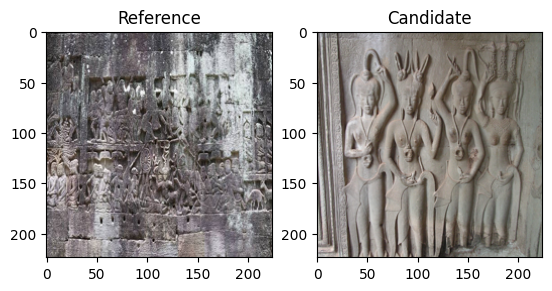

****************************************************************************************************
******* Reference-3 *******
=== Candidate #0 ===
Reference Caption: To what era does this bas-relief belong? 12th-13th century
Candidate Caption: None
Culture: cambodia
Score:0.7622358798980713


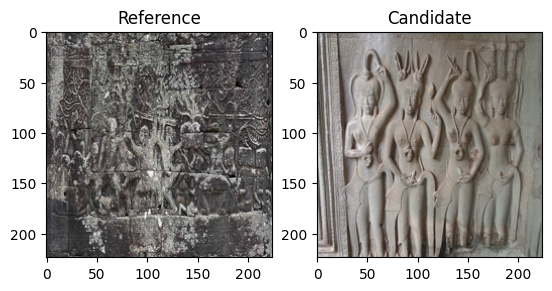

****************************************************************************************************
******* Reference-9 *******
=== Candidate #0 ===
Reference Caption: What could the different colors seen in the decorations signify in Cambodian culture? Representations of different spiritual realms
Candidate Caption: Dua orang penari Bali sedang melakukan tarian Sanghyang Dedari
Culture: cambodia
Score:0.7736949920654297


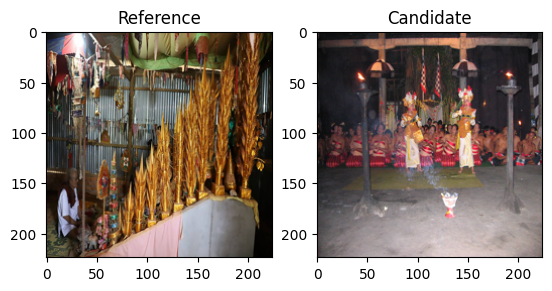

****************************************************************************************************
******* Reference-11 *******
=== Candidate #0 ===
Reference Caption: The facial expressions combined with the gestures in dance primarily aim to: Portray joy and festivity
Candidate Caption: Penari belia sedang menarikan Tari Belibis, koreografi kontemporer karya Ni Luh Suasthi Bandem.
Culture: cambodia
Score:0.712119460105896


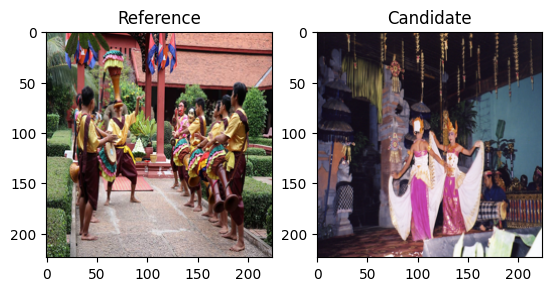

****************************************************************************************************
******* Reference-12 *******
=== Candidate #0 ===
Reference Caption: What is the most probable time of day for this martial arts demonstration based on the lighting and shadows in the image? Midday
Candidate Caption: None
Culture: cambodia
Score:0.7213325500488281
  >>>UnidentifiedImageError<<<



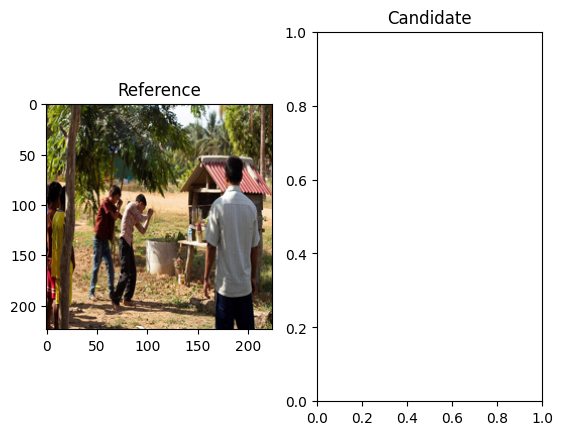

****************************************************************************************************
******* Reference-17 *******
=== Candidate #0 ===
Reference Caption: What notable feature of the event is specifically tied to Cambodian cultural practices? The use of mats for the performance
Candidate Caption: None
Culture: cambodia
Score:0.6810002326965332
  >>>UnidentifiedImageError<<<



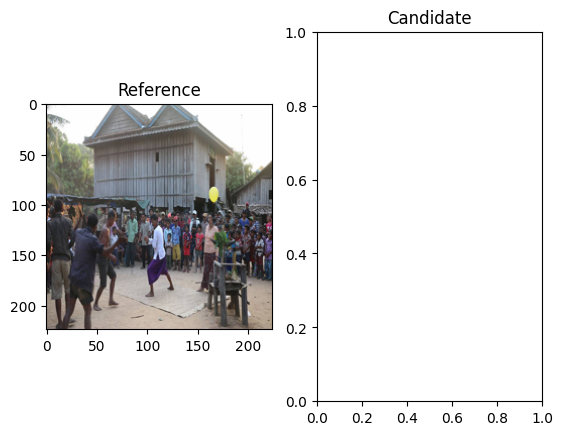

****************************************************************************************************


In [30]:
top_k=1
last_embed = None
for idx in range(20):
    if last_embed is None:
        last_embed = ref_images_embed[idx]
    elif (last_embed == ref_images_embed[idx]).all():
        continue
    elif (last_embed != ref_images_embed[idx]).all():
        last_embed = ref_images_embed[idx]

    sorted_index = np.argsort(np.array(wit_val_ref_scores[idx]))[::-1]
    image = ref_images_filt[idx]
    caption = ref_vqa_caption[idx]
    culture = ref_vqa_culture[idx]

    print(f"******* Reference-{idx} *******")
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        print(f"=== Candidate #{rank} ===")
        print(f"Reference Caption: {caption}")
        print(f"Candidate Caption: {wit_val_caption[cand_idx]}")
        print(f"Culture: {culture}")
        print(f"Score:{wit_val_ref_scores[idx][cand_idx]}")

        fig, (ax1, ax2) = plt.subplots(1, 2)

        # Display the first PIL Image in the left subplot
        ax1.imshow(image.resize((224, 224), Image.BICUBIC))
        ax1.set_title('Reference')

        # Display the second PIL Image in the right subplot
        try:
            ax2.imshow(Image.open(requests.get(wit_val_images_filt[cand_idx], stream=True, timeout=5).raw).resize((224, 224), Image.BICUBIC))
        except PIL.UnidentifiedImageError as e:
            print("  >>>UnidentifiedImageError<<<\n")
        ax2.set_title('Candidate')
        plt.show()
    print("*"*100)

In [29]:
top_k=1
last_embed = None
for idx in range(len(ref_images_filt) - 10, len(ref_images_filt)):
    if last_embed is None:
        last_embed = ref_images_embed[idx]
    elif (last_embed == ref_images_embed[idx]).all():
        continue
    elif (last_embed != ref_images_embed[idx]).all():
        last_embed = ref_images_embed[idx]

    sorted_index = np.argsort(np.array(wit_val_ref_scores[idx]))[::-1]
    image = ref_images_filt[idx]
    caption = ref_vqa_caption[idx]
    culture = ref_vqa_culture[idx]

    print(f"******* Reference-{idx} *******")
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        print(f"=== Candidate #{rank} ===")
        print(f"Reference Caption: {caption}")
        print(f"Candidate Caption: {wit_val_caption[cand_idx]}")
        print(f"Culture: {culture}")
        print(f"Score:{wit_val_ref_scores[idx][cand_idx]}")

        fig, (ax1, ax2) = plt.subplots(1, 2)

        # Display the first PIL Image in the left subplot
        ax1.imshow(image.resize((224, 224), Image.BICUBIC))
        ax1.set_title('Reference')

        # Display the second PIL Image in the right subplot
        try:
            ax2.imshow(Image.open(requests.get(wit_val_images_filt[cand_idx], stream=True, timeout=5).raw).resize((224, 224), Image.BICUBIC))
        except PIL.UnidentifiedImageError as e:
            print("  >>>UnidentifiedImageError<<<\n")
            # continue
        ax2.set_title('Candidate')
        plt.show()
    print("*"*100)

Output hidden; open in https://colab.research.google.com to view.

##### Mean Vector

******* Mean Reference *******
=== Candidate #0 ===
Candidate Caption: None
Score:0.5546789169311523
  >>>UnidentifiedImageError<<<

=== Candidate #1 ===
Candidate Caption: Dua orang penari Bali sedang melakukan tarian Sanghyang Dedari
Score:0.5542562007904053


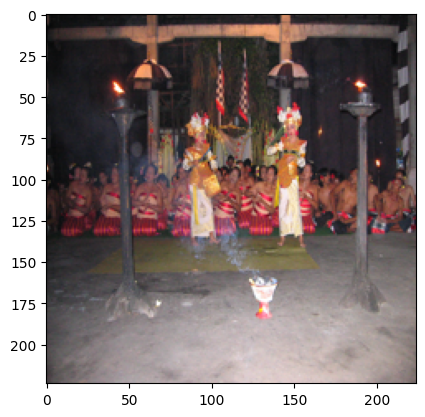

=== Candidate #2 ===
Candidate Caption: None
Score:0.552611768245697
  >>>UnidentifiedImageError<<<

=== Candidate #3 ===
Candidate Caption: Cầu khỉ ở ấp Phú Thạnh, xã Phú Hữu, An Phú.
Score:0.5453636050224304
  >>>UnidentifiedImageError<<<

=== Candidate #4 ===
Candidate Caption: Penari belia sedang menarikan Tari Belibis, koreografi kontemporer karya Ni Luh Suasthi Bandem.
Score:0.5402287840843201


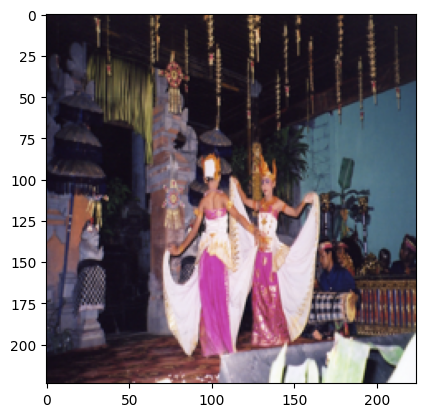

=== Candidate #5 ===
Candidate Caption: Toko Kompak, Pasar Baru
Score:0.5398982763290405
  >>>UnidentifiedImageError<<<

=== Candidate #6 ===
Candidate Caption: Toko Kompak, kediaman keluarga Kapitan Tio Tek Ho.
Score:0.5398982763290405
  >>>UnidentifiedImageError<<<

=== Candidate #7 ===
Candidate Caption: None
Score:0.5396594405174255
  >>>UnidentifiedImageError<<<

=== Candidate #8 ===
Candidate Caption: Cánh đồng lúa
Score:0.5359852910041809


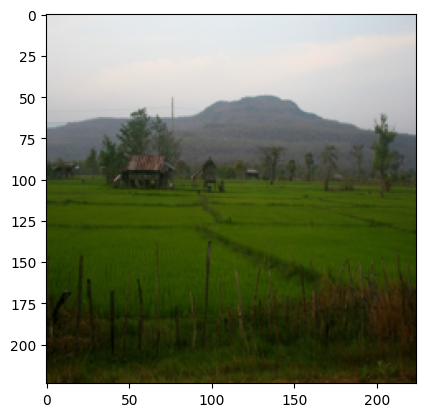

=== Candidate #9 ===
Candidate Caption: Lukisan di sebuah wihara di Sravasti, India, yang menggambarkan Angulimala sedang mencoba mengejar Buddha Gautama.
Score:0.5347594618797302


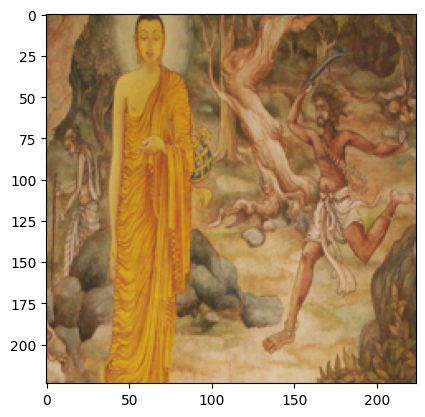

****************************************************************************************************


In [32]:
top_k=10
last_embed = None

mean_ref_score = wit_val_ref_scores.mean(dim=0)

sorted_index = np.argsort(np.array(mean_ref_score))[::-1]

print(f"******* Mean Reference *******")
for rank, cand_idx in enumerate(sorted_index[:top_k]):
    print(f"=== Candidate #{rank} ===")
    print(f"Candidate Caption: {wit_val_caption[cand_idx]}")
    print(f"Score:{mean_ref_score[cand_idx]}")

    # Display the second PIL Image in the right subplot
    try:
        plt.imshow(Image.open(requests.get(wit_val_images_filt[cand_idx], stream=True, timeout=5).raw).resize((224, 224), Image.BICUBIC))
    except PIL.UnidentifiedImageError as e:
        print("  >>>UnidentifiedImageError<<<\n")
    plt.show()
print("*"*100)

In [ ]:
# request without header

Output hidden; open in https://colab.research.google.com to view.